## Import libraries

- Follow instructions on this link to sign up for Google Earth Engine - https://geemap.org/installation/

In [1]:
import ee
# ee.Authenticate()
ee.Initialize()

In [2]:
import sys
import os
import geemap
# import geemap.colormaps as cm

In [3]:
print(f"""System: {sys.version} 
geemap: {geemap.__version__}
ee: {ee.__version__} 
        """)     

System: 3.12.7 | packaged by conda-forge | (main, Oct  4 2024, 15:57:01) [Clang 17.0.6 ] 
geemap: 0.34.5
ee: 1.1.3 
        


In [4]:
# example AOI to search Landsat images
polygon = ee.Geometry.Polygon([
    [[-92.625046, 38.351888],
  [-92.625046, 38.416342],
  [-92.52943, 38.416342],
  [-92.52943, 38.351888],
  [-92.625046, 38.351888]]
  ])

## Get HLS Landsat-8 images
[Info](https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSL30_v002)

In [5]:
# Function to extract the Fmask band and apply the bitmask for cloud, shadow, snow
def maskCloudSnowShadow(image):
    # Select the Fmask band
    fmask = image.select('Fmask')
    # Extract bits: 1 (cloud), 3 (shadow), 4 (snow)
    cloudBit = 1 << 1
    shadowBit = 1 << 3
    snowBit = 1 << 4
    # Create MAsk
    cloudMask = fmask.bitwiseAnd(cloudBit).neq(0)  # 1 if cloud
    shadowMask = fmask.bitwiseAnd(shadowBit).neq(0)  # 1 if shadow
    snowMask = fmask.bitwiseAnd(snowBit).neq(0)  # 1 if snow
    mask = cloudMask.Or(shadowMask).Or(snowMask)  # 1 if any bad
    return image.updateMask(mask.Not())  # Keep where mask=0


In [ ]:
# get HLS image collection
HLS_ls8 = (
    ee.ImageCollection("NASA/HLS/HLSL30/v002")
    .filterDate("2023-05-01", "2023-06-01")
    .filter(ee.Filter.lte("CLOUD_COVERAGE", 40))
    .filterBounds(polygon)
    .map(maskCloudSnowShadow)
    .select(["B2", "B3", "B4", "B5", "Fmask"]) # select band names to include
    
)  

print(f"Total number of images = {HLS_ls8.size().getInfo()}")

Total number of images = 3


In [ ]:
import xarray
import matplotlib.pyplot as plt
import numpy as np

In [8]:
HLS_ls8.first().projection().crs().getInfo()

'EPSG:32615'

In [32]:
ds = xarray.open_dataset(
    HLS_ls8,
    engine="ee",  # Use XEE engine for Earth Engine integration
    crs=HLS_ls8.first().projection().crs().getInfo(),  # CRS from collection
    geometry=polygon.bounds(),  # Use bounding rectangle as geometry
    scale=30,  # Spatial resolution in meters (10m for Sentinel-2)
)

In [22]:
np.unique(ds.Fmask.values)

array([ 64.,  68.,  96., 100., 128., 132., 160., 164., 192., 196., 224.,
        nan], dtype=float32)

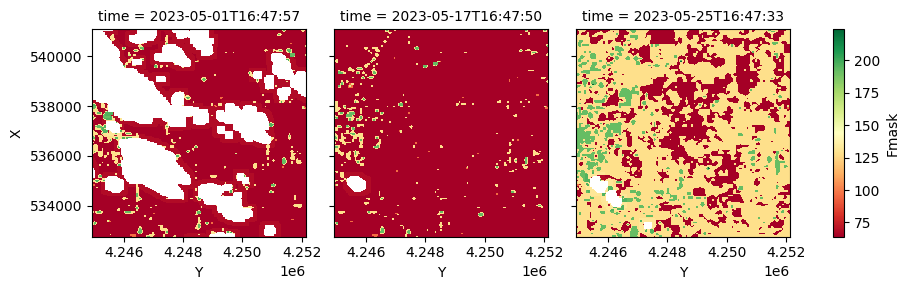

In [17]:
ds["Fmask"].plot(col="time", col_wrap=3, cmap="RdYlGn")
plt.show()

In [ ]:
# Visualize using geemap
Map = geemap.Map(center=(40, -100), zoom=4, basemap="HYBRID")
Map.centerObject(polygon)
visualization = {
    "bands": ["B4", "B3", "B2"],
    "min": 0.0,
    "max": 0.3,
}

Map.addLayer(HLS_ls8.first().clip(polygon), visualization, "RGB")

Map

In [ ]:
%%script echo skipping
# Visualize using geemap
Map = geemap.Map(center=(40, -100), zoom=4, basemap="HYBRID")
Map.centerObject(polygon)
visualization = {
    "bands": ["B4_median", "B3_median", "B2_median"],
    "min": 0.0,
    "max": 0.3,
}

Map.addLayer(HLS_ls8.reduce(ee.Reducer.median()).clip(polygon), visualization, "Median RGB")

Map